In [1]:
# --- Core imports used across the notebook ---
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

# fixed seeds so the behaviour is repeatable
np.random.seed(0)
random.seed(0)


In [1]:
# MENACE-style tic-tac-toe agent (3×3)

def rotations_and_reflections(board):
    grid = np.array(board).reshape(3, 3)
    variants = []

    # Generate 4 rotations and a mirror version of each
    for k in range(4):
        rotated = np.rot90(grid, k)
        variants.append(tuple(rotated.flatten()))
        variants.append(tuple(np.fliplr(rotated).flatten()))

    return variants


def canonical_board(board):
    # Pick the lexicographically smallest symmetric version
    return min(rotations_and_reflections(board))


def legal_moves(board):
    # Empty squares are coded as 0
    return [idx for idx, val in enumerate(board) if val == 0]


def check_winner(board):
    g = np.array(board).reshape(3, 3)

    # Check rows and columns first
    for i in range(3):
        row_sum = g[i].sum()
        if abs(row_sum) == 3:
            return int(np.sign(row_sum))

        col_sum = g[:, i].sum()
        if abs(col_sum) == 3:
            return int(np.sign(col_sum))

    # Then both diagonals
    diag1 = g.trace()
    diag2 = np.fliplr(g).trace()

    if abs(diag1) == 3:
        return int(np.sign(diag1))
    if abs(diag2) == 3:
        return int(np.sign(diag2))

    # Draw if no empty squares remain
    if 0 not in board:
        return 0

    return None   # game still in progress


class MENACE:
    def __init__(self, init_beads=3):
        # "boxes" store bead counts for each canonical board state
        self.boxes = {}
        self.init_beads = init_beads
        self.episode_moves = []  # (box_key, chosen_move) pairs

    def ensure_box(self, board):
        key = canonical_board(board)
        if key not in self.boxes:
            moves = legal_moves(list(key))
            # Start each move with init_beads copies
            self.boxes[key] = Counter({m: self.init_beads for m in moves})
        return key

    def choose_move(self, board):
        key = self.ensure_box(board)
        bead_counts = self.boxes[key]
        total = sum(bead_counts.values())

        if total == 0:
            # If punished too much, fall back to uniform choice
            move = random.choice(list(bead_counts.keys()))
        else:
            # Weighted random draw proportional to bead counts
            threshold = random.uniform(0, total)
            cumulative = 0
            for m, c in bead_counts.items():
                cumulative += c
                if cumulative >= threshold:
                    move = m
                    break

        self.episode_moves.append((key, move))
        return move

    def update(self, result):
        # Reward or penalize based on game outcome
        for box_key, mv in self.episode_moves:
            if box_key not in self.boxes:
                continue

            if result == 1:
                self.boxes[box_key][mv] += 3    # win reward
            elif result == 0:
                self.boxes[box_key][mv] += 1    # draw reward
            else:
                # loss: remove one bead but don't go negative
                self.boxes[box_key][mv] = max(0, self.boxes[box_key][mv] - 1)

        self.episode_moves = []


In [3]:
def play_game_menace(menace):
    board = [0]*9
    turn = 1  # MENACE (1) starts
    while True:
        if turn == 1:
            move = menace.choose_move(board)
            board[move] = 1
        else:
            moves = legal_moves(board)
            move = random.choice(moves)
            board[move] = -1
        w = check_winner(board)
        if w is not None:
            # w == 1 -> MENACE win; 0 draw; -1 loss
            menace.update(w)
            return w
        turn *= -1

# Train for some games and show progress
menace = MENACE(init_beads=3)
N_games = 2000
results = {1:0, 0:0, -1:0}
for i in range(N_games):
    r = play_game_menace(menace)
    results[r] += 1
    if (i+1) % 500 == 0:
        print(f"After {i+1} games: wins={results[1]}, draws={results[0]}, losses={results[-1]}")

print("Final results (wins/draws/losses):", results)


After 500 games: wins=255, draws=42, losses=203
After 1000 games: wins=549, draws=84, losses=367
After 1500 games: wins=836, draws=117, losses=547
After 2000 games: wins=1126, draws=171, losses=703
Final results (wins/draws/losses): {1: 1126, 0: 171, -1: 703}


In [4]:
class BinaryBandit:
    def __init__(self, p_success):
        self.p = np.array(p_success, dtype=float)
    def step(self, action):
        return 1 if np.random.random() < self.p[action] else 0

class EpsilonGreedyAgent:
    def __init__(self, n_actions=2, epsilon=0.1, initial=0.0, sample_average=True, alpha=None):
        self.n = n_actions
        self.epsilon = epsilon
        self.q = np.ones(n_actions) * initial
        self.counts = np.zeros(n_actions, dtype=int)
        self.sample_average = sample_average
        self.alpha = alpha
    def select(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n)
        else:
            return int(np.argmax(self.q))
    def update(self, a, r):
        self.counts[a] += 1
        if self.sample_average:
            self.q[a] += (r - self.q[a]) / self.counts[a]
        else:
            a_step = self.alpha if self.alpha is not None else 0.1
            self.q[a] += a_step * (r - self.q[a])


In [5]:
# Bandit definitions
banditA = BinaryBandit([0.2, 0.8])
banditB = BinaryBandit([0.45, 0.55])

def run_bandit_demo(bandit, eps=0.1, steps=500):
    agent = EpsilonGreedyAgent(n_actions=2, epsilon=eps, sample_average=True)
    rewards = []
    for t in range(steps):
        a = agent.select()
        r = bandit.step(a)
        agent.update(a, r)
        rewards.append(r)
    return np.array(rewards), agent

rA, agentA = run_bandit_demo(banditA, eps=0.1, steps=1000)
rB, agentB = run_bandit_demo(banditB, eps=0.1, steps=1000)

print("Bandit A last-100 avg reward:", rA[-100:].mean())
print("Bandit B last-100 avg reward:", rB[-100:].mean())


Bandit A last-100 avg reward: 0.79
Bandit B last-100 avg reward: 0.52


In [6]:
class NonStationaryBandit:
    def __init__(self, k=10, mu_init=0.0, walk_std=0.01):
        self.k = k
        self.mu = np.full(k, mu_init, dtype=float)
        self.walk_std = walk_std

    def step(self, action):
        # reward comes from a Gaussian centered at the drifting mean
        mean_val = self.mu[action]
        return np.random.normal(mean_val, 1.0)

    def random_walk(self):
        # each arm's mean drifts slightly every step
        drift = np.random.normal(0.0, self.walk_std, size=self.k)
        self.mu += drift

    def optimal_action(self):
        return int(np.argmax(self.mu))


def experiment_nonstationary(runs=200, time_steps=10000, epsilon=0.1, alpha=0.1):
    k = 10

    avg_rewards_sample = np.zeros(time_steps)
    avg_opt_sample = np.zeros(time_steps)
    avg_rewards_const = np.zeros(time_steps)
    avg_opt_const = np.zeros(time_steps)

    for run in range(runs):
        env = NonStationaryBandit(k=k, mu_init=0.0, walk_std=0.01)

        agent_sample = EpsilonGreedyAgent(
            n_actions=k, epsilon=epsilon, sample_average=True
        )
        agent_const = EpsilonGreedyAgent(
            n_actions=k, epsilon=epsilon, sample_average=False, alpha=alpha
        )

        rewards_s = np.zeros(time_steps)
        rewards_c = np.zeros(time_steps)
        opt_s = np.zeros(time_steps)
        opt_c = np.zeros(time_steps)

        for t in range(time_steps):
            # sample-average agent
            a_s = agent_sample.select()
            r_s = env.step(a_s)
            agent_sample.update(a_s, r_s)

            # constant-alpha agent
            a_c = agent_const.select()
            r_c = env.step(a_c)
            agent_const.update(a_c, r_c)

            rewards_s[t] = r_s
            rewards_c[t] = r_c

            best = env.optimal_action()
            opt_s[t] = 1.0 if a_s == best else 0.0
            opt_c[t] = 1.0 if a_c == best else 0.0

            env.random_walk()

        avg_rewards_sample += rewards_s
        avg_rewards_const += rewards_c
        avg_opt_sample += opt_s
        avg_opt_const += opt_c

        if (run + 1) % 50 == 0:
            print(f"Completed run {run+1}/{runs}")

    avg_rewards_sample /= runs
    avg_rewards_const /= runs
    avg_opt_sample /= runs
    avg_opt_const /= runs

    return (
        avg_rewards_sample,
        avg_opt_sample,
        avg_rewards_const,
        avg_opt_const,
    )


In [7]:
# WARNING: This block is computationally heavy. 
# If your system starts to lag, try lowering `runs` or `time_steps`.

runs = 200
time_steps = 10000
epsilon = 0.1
alpha = 0.1

avg_rewards_sample, avg_opt_sample, avg_rewards_const, avg_opt_const = (
    experiment_nonstationary(
        runs=runs,
        time_steps=time_steps,
        epsilon=epsilon,
        alpha=alpha
    )
)


Completed run 50/200
Completed run 100/200
Completed run 150/200
Completed run 200/200


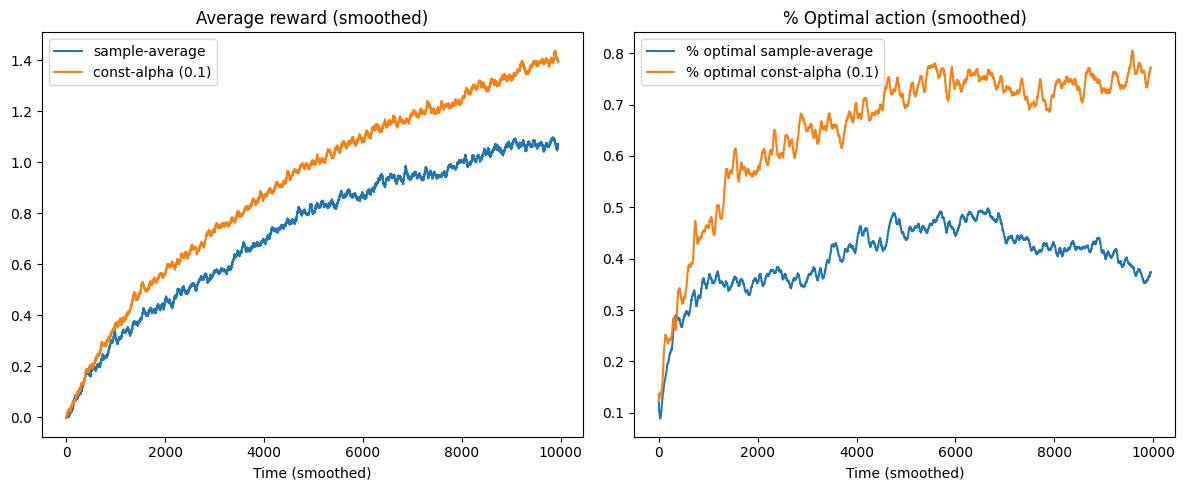

In [8]:
# smoothing helper
def smooth(x, window=50):
    if len(x) < window:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / window

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(smooth(avg_rewards_sample), label='sample-average')
plt.plot(smooth(avg_rewards_const), label='const-alpha (0.1)')
plt.title('Average reward (smoothed)')
plt.xlabel('Time (smoothed)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smooth(avg_opt_sample), label='% optimal sample-average')
plt.plot(smooth(avg_opt_const), label='% optimal const-alpha (0.1)')
plt.title('% Optimal action (smoothed)')
plt.xlabel('Time (smoothed)')
plt.legend()

plt.tight_layout()
plt.show()
